In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, wait
from dask import array as darr

from pathlib import Path

import hextraj

In [3]:
import cartopy
from matplotlib import pyplot as plt

## Parameters

We need to specify a few things for the trajectory data (location, chunks).

We also need to specify the hex projectoin. We choose a central position well withing the NWE shelf region (3W, 54.5N) and a hex size (radius) of 10 km

In [4]:
# parameters

data_path = "../../../output_data/010_lagrangian_experiment_15m.zarr/"
_chunks_traj = 20_000
_chunks_obs = -1

chunks_traj = 20_000
chunks_obs = -1

# ~ center of NWE Shelf dataset
lon_origin = -3.0
lat_origin = 54.5

hex_size_meters = 10_000  # radius of hexes

max_land_allowed = 0

## Dask

In [6]:
#client = Client(n_workers=2, threads_per_worker=4, memory_limit=32e9, ip="0.0.0.0")
client = Client(scheduler_file="../../../scheduler.json")
client.restart()
client

Connection method: Scheduler file,Scheduler file: ../../../scheduler.json
Dashboard: http://10.0.4.101:43499/status,
Comm: tcp://10.0.4.101:8786,Workers: 0
Dashboard: http://10.0.4.101:43499/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
ds = xr.open_zarr(data_path)
ds

<xarray.Dataset> Size: 1TB
Dimensions:      (year: 4, offset: 122, traj: 100000, obs: 673)
Coordinates:
  * offset       (offset) int64 976B 0 1 2 3 4 5 6 ... 116 117 118 119 120 121
Dimensions without coordinates: year, traj, obs
Data variables:
    land         (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    lat          (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    lon          (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    salinity     (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    temperature  (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    time         (year, offset, traj, obs) datetime64[ns] 263GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    trajectory   (year, offset, traj, obs) float64 263GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    z            (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.3.1

In [8]:
print(ds.nbytes / 1e9, "GiB")

1313.696000976 GiB


## Create the hex projection and label all positions

Labelling is done lazily (no labels actually computed until we really request values).

In [9]:
hex_proj = hextraj.HexProj(
    lon_origin=lon_origin,
    lat_origin=lat_origin,
    hex_size_meters=hex_size_meters,
)

/opt/conda/envs/parcels/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [10]:
ds["hex"] = xr.apply_ufunc(
    hex_proj.lon_lat_to_hex_AoS,
    ds.lon, ds.lat,  # both have same shape
    dask="parallelized",
    output_dtypes=[tuple, ],
).rename("hex")

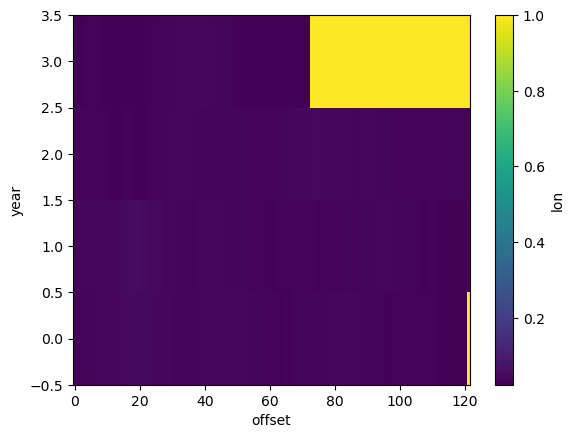

In [11]:
ds.lon.isnull().mean("obs").mean("traj").compute().plot()

## Remove trajectories which touch land

### Where do land-touching trajs start?

In [12]:
%%time

touches_land = ((ds.land > max_land_allowed).sum("obs") > 0)

CPU times: user 10.8 ms, sys: 1.96 ms, total: 12.7 ms
Wall time: 12.3 ms


In [13]:
touches_land

<xarray.DataArray 'land' (year: 4, offset: 122, traj: 100000)> Size: 49MB
dask.array<gt, shape=(4, 122, 100000), dtype=bool, chunksize=(1, 1, 20000), chunktype=numpy.ndarray>
Coordinates:
  * offset   (offset) int64 976B 0 1 2 3 4 5 6 7 ... 115 116 117 118 119 120 121
Dimensions without coordinates: year, traj

In [14]:
touches_land = touches_land.compute()

<Axes: xlabel='offset'>

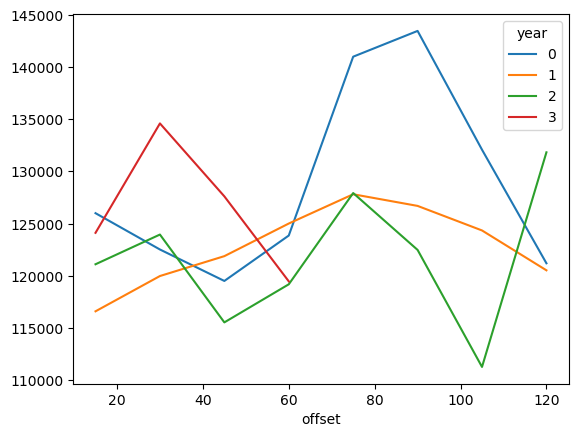

In [15]:
touches_land.sum(["traj"]).where(touches_land.mean(["traj"]) > 0).to_pandas().T.cumsum().iloc[::15].diff().plot()

<Axes: xlabel='offset'>

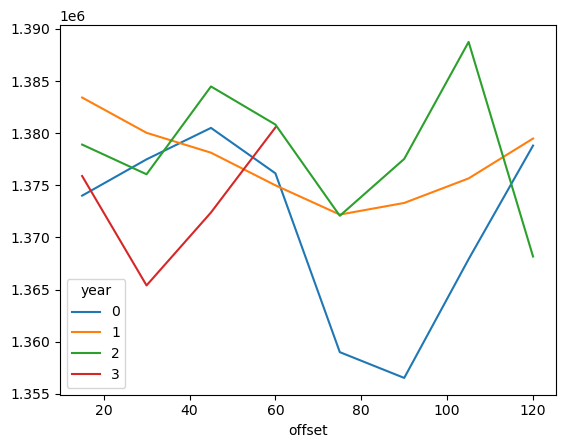

In [16]:
(~touches_land).sum(["traj"]).where(touches_land.mean(["traj"]) > 0).to_pandas().T.cumsum().iloc[::15].diff().plot()

In [17]:
touches_land_pos = ds.where(touches_land).isel(obs=0, offset=0, drop=True).compute()
touches_land_pos = touches_land_pos[["lon", "lat"]].to_dataframe().dropna()
touches_land_pos

/opt/conda/envs/parcels/lib/python3.12/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 46.59 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


lon        lat
year traj                      
0    1      1.786838  53.103645
     52    -3.836258  47.776379
     59    -2.882884  50.619652
     73     4.100185  52.080589
     74     7.451475  56.881699
...              ...        ...
3    99873 -6.003767  53.680779
     99877  6.996541  56.637104
     99890 -0.375437  49.396976
     99920  6.709609  53.873875
     99934  1.754787  53.162632

[32359 rows x 2 columns]

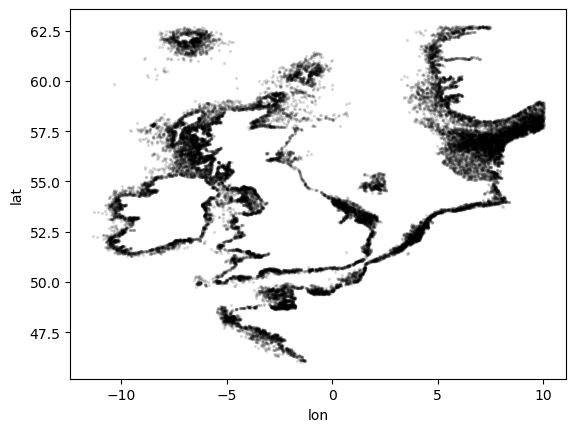

In [18]:
touches_land_pos.plot.scatter(x="lon", y="lat", s=2, color="black", alpha=0.1);

### How many trajs will be lost?

In [19]:
touches_land.mean(["traj", "offset"]).compute()

<xarray.DataArray 'land' (year: 4)> Size: 32B
array([0.08506975, 0.08184893, 0.08116828, 0.05026246])
Dimensions without coordinates: year

So there's up to 10% of all trajectories going missing due to land contact.

### Finally, mask the land-touching trajs away

In [20]:
ds = ds.where(~touches_land)
ds

<xarray.Dataset> Size: 2TB
Dimensions:      (year: 4, offset: 122, traj: 100000, obs: 673)
Coordinates:
  * offset       (offset) int64 976B 0 1 2 3 4 5 6 ... 116 117 118 119 120 121
Dimensions without coordinates: year, traj, obs
Data variables:
    land         (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    lat          (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    lon          (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    salinity     (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    temperature  (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    time         (year, offset, traj, obs) datetime64[ns] 263GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    trajectory   (year, offset, traj, obs) float64 263GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    z            (year, offset, traj, obs) float32 131GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
    hex          (year, offset, traj, obs) object 263GB dask.array<chunksize=(1, 1, 20000, 673), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.3.1

### To dataframe

This is a little hacky, but a simple `xr.DataArray.to_dask_dataframe()` does not necesarily ensure the dataframe is partitioned in a way that aligns well with the Dask array chunks.

In [21]:
from dask import dataframe as ddf

In [22]:
ds = ds.transpose("offset", "year", "traj", "obs")

In [23]:
obs = darr.broadcast_to(
    darr.arange(ds.dims["obs"], chunks=(-1, )),
    shape=ds.hex.data.shape,
    chunks=ds.hex.data.chunks,
).reshape(-1, ds.dims["obs"]).reshape(-1, )

obs

/tmp/ipykernel_358112/90699957.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  darr.arange(ds.dims["obs"], chunks=(-1, )),
/tmp/ipykernel_358112/90699957.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ).reshape(-1, ds.dims["obs"]).reshape(-1, )


dask.array<reshape, shape=(32842400000,), dtype=int64, chunksize=(13460000,), chunktype=numpy.ndarray>

In [24]:
offset = darr.broadcast_to(
    darr.arange(ds.dims["offset"], chunks=(1, )).reshape(-1, 1, 1, 1),
    shape=ds.hex.data.shape,
    chunks=ds.hex.data.chunks,
).reshape(-1, ds.dims["obs"]).reshape(-1, )

offset

/tmp/ipykernel_358112/2658399699.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  darr.arange(ds.dims["offset"], chunks=(1, )).reshape(-1, 1, 1, 1),
/tmp/ipykernel_358112/2658399699.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ).reshape(-1, ds.dims["obs"]).reshape(-1, )


dask.array<reshape, shape=(32842400000,), dtype=int64, chunksize=(13460000,), chunktype=numpy.ndarray>

In [25]:
year = darr.broadcast_to(
    darr.arange(ds.dims["year"], chunks=(1, )).reshape(1, -1, 1, 1),
    shape=ds.hex.data.shape,
    chunks=ds.hex.data.chunks,
).reshape(-1, ds.dims["obs"]).reshape(-1, )

year

/tmp/ipykernel_358112/417374451.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  darr.arange(ds.dims["year"], chunks=(1, )).reshape(1, -1, 1, 1),
/tmp/ipykernel_358112/417374451.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ).reshape(-1, ds.dims["obs"]).reshape(-1, )


dask.array<reshape, shape=(32842400000,), dtype=int64, chunksize=(13460000,), chunktype=numpy.ndarray>

In [26]:
hexes0 = darr.broadcast_to(
    ds.hex.isel(obs=[0, ]).data,
    shape=ds.hex.data.shape,
    chunks=ds.hex.data.chunks,
).reshape(-1, ds.dims["obs"]).reshape(-1, )

hexes0

/tmp/ipykernel_358112/2906211369.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ).reshape(-1, ds.dims["obs"]).reshape(-1, )


dask.array<reshape, shape=(32842400000,), dtype=object, chunksize=(13460000,), chunktype=numpy.ndarray>

In [27]:
hexes1 = ds.hex.data.reshape(-1, ds.dims["obs"]).reshape(-1, )
hexes1

/tmp/ipykernel_358112/155070402.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  hexes1 = ds.hex.data.reshape(-1, ds.dims["obs"]).reshape(-1, )


dask.array<reshape, shape=(32842400000,), dtype=object, chunksize=(13460000,), chunktype=numpy.ndarray>

In [28]:
df_obs = ddf.from_dask_array(obs, columns=["obs", ])
df_obs

,obs
npartitions=2440,
0,int64
13460000,...
...,...
32828940000,...
32842399999,...


In [29]:
df_offset = ddf.from_dask_array(offset, columns=["offset", ])
df_offset

,offset
npartitions=2440,
0,int64
13460000,...
...,...
32828940000,...
32842399999,...


In [30]:
df_year = ddf.from_dask_array(year, columns=["year", ])
df_year

,year
npartitions=2440,
0,int64
13460000,...
...,...
32828940000,...
32842399999,...


In [31]:
df_hex1 = ddf.from_dask_array(hexes1, columns=["hex1", ])
df_hex1

,hex1
npartitions=2440,
0,string
13460000,...
...,...
32828940000,...
32842399999,...


In [32]:
df_hex0 = ddf.from_dask_array(hexes0, columns=["hex0", ])
df_hex0

,hex0
npartitions=2440,
0,string
13460000,...
...,...
32828940000,...
32842399999,...


In [33]:
df_joined = df_obs.join(df_offset).join(df_year).join(df_hex0).join(df_hex1)
df_joined

,obs,offset,year,hex0,hex1
npartitions=2440,,,,,
0,int64,int64,int64,string,string
13460000,...,...,...,...,...
...,...,...,...,...,...
32828940000,...,...,...,...,...
32842399999,...,...,...,...,...


In [34]:
df_joined = df_joined.join(
    (df_joined["offset"] / 30).apply(np.floor).rename("month").to_frame()
)

/opt/conda/envs/parcels/lib/python3.12/site-packages/dask_expr/_collection.py:4376: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('offset', 'float64'))

  warnings.warn(meta_warning(meta))


In [35]:
obs_dt = (
    ds.time.diff("obs").isel(obs=1, traj=0, offset=0, year=0).compute().data[()] 
    / np.timedelta64(1, "h")
)
obs_dt

/opt/conda/envs/parcels/lib/python3.12/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 46.54 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


1.0

In [36]:
df_joined = df_joined.join(
    (df_joined["obs"] * obs_dt / 24).apply(np.floor).rename("days_travelled").to_frame()
)

/opt/conda/envs/parcels/lib/python3.12/site-packages/dask_expr/_collection.py:4376: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('obs', 'float64'))

  warnings.warn(meta_warning(meta))


In [37]:
df_joined

,obs,offset,year,hex0,hex1,month,days_travelled
npartitions=2440,,,,,,,
0,int64,int64,int64,string,string,float64,float64
13460000,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
32828940000,...,...,...,...,...,...,...
32842399999,...,...,...,...,...,...,...


In [38]:
connection_count = df_joined.groupby(["days_travelled", "month", "year", "hex0", "hex1"])["obs"].count()
connection_count

Dask Series Structure:
npartitions=1
    int64
      ...
Dask Name: count, 24 expressions
Expr=Count(frame=Merge(6f35764)[['obs', 'year', 'hex0', 'hex1', 'month', 'days_travelled']], observed=False, _slice='obs')

In [39]:
%%time

connection_count = connection_count.compute()

/opt/conda/envs/parcels/lib/python3.12/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 53.04 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 5.01 s, sys: 8.84 s, total: 13.9 s
Wall time: 32min 43s


In [40]:
connection_count

days_travelled  month  year  hex0            hex1          
0.0             0.0    0     (-28, 53, -25)  (-28, 52, -24)    422
                             (-31, -16, 47)  (-30, -16, 46)    473
                             (-32, 59, -27)  (-31, 57, -26)     34
                             (-53, -19, 72)  (-54, -19, 73)    970
                             (11, 8, -19)    (12, 7, -19)      296
                                                              ... 
27.0            4.0    2     (-49, 43, 6)    (-33, 29, 4)       12
                             (2, 28, -30)    (10, 15, -25)      12
28.0            4.0    2     (-28, 68, -40)  (-19, 61, -42)      1
                             (-30, 39, -9)   (-22, 36, -14)      1
                             (-36, 54, -18)  (-36, 48, -12)      1
Name: obs, Length: 230348005, dtype: int64

### Fill in missing hexes

In [41]:
h0 = set(connection_count.reset_index().hex0)
h1 = set(connection_count.reset_index().hex1)
all_hexes = h0.union(h1)
h0_missing = all_hexes.difference(h0)
h1_missing = all_hexes.difference(h1)

len(h0_missing), len(h1_missing)

(77, 0)

In [42]:
missing_index = pd.MultiIndex.from_product(
    [[0.0, ], [0.0, ], [0.0, ], list(h0_missing), list(h1_missing)],
    names=["days_travelled","month", "year", "hex0", "hex1"], 
)
missing_count = pd.Series(
    np.zeros(shape=(len(missing_index), ), dtype=int),
    index=missing_index,
    name="obs",
)
missing_count

Series([], Name: obs, dtype: int64)

In [43]:
new_connection_count = pd.concat([connection_count, missing_count], ignore_index=False)
assert len(new_connection_count) - len(missing_count) == len(connection_count)
connection_count = new_connection_count

In [44]:
connection_count

days_travelled  month  year  hex0            hex1          
0.0             0.0    0.0   (-28, 53, -25)  (-28, 52, -24)    422
                             (-31, -16, 47)  (-30, -16, 46)    473
                             (-32, 59, -27)  (-31, 57, -26)     34
                             (-53, -19, 72)  (-54, -19, 73)    970
                             (11, 8, -19)    (12, 7, -19)      296
                                                              ... 
27.0            4.0    2.0   (-49, 43, 6)    (-33, 29, 4)       12
                             (2, 28, -30)    (10, 15, -25)      12
28.0            4.0    2.0   (-28, 68, -40)  (-19, 61, -42)      1
                             (-30, 39, -9)   (-22, 36, -14)      1
                             (-36, 54, -18)  (-36, 48, -12)      1
Name: obs, Length: 230348005, dtype: int64

In [45]:
type(connection_count)

pandas.core.series.Series

In [46]:
connection_count.to_frame().to_parquet("../../../output_data/020_connection_count_15m/020_connection_count_15m.pq")

In [47]:
connection_count = pd.read_parquet('../../../output_data/020_connection_count_15m/020_connection_count_15m.pq')

In [48]:
connection_count

obs
days_travelled month year hex0           hex1               
0.0            0.0   0.0  (-28, 53, -25) (-28, 52, -24)  422
                          (-31, -16, 47) (-30, -16, 46)  473
                          (-32, 59, -27) (-31, 57, -26)   34
                          (-53, -19, 72) (-54, -19, 73)  970
                          (11, 8, -19)   (12, 7, -19)    296
...                                                      ...
27.0           4.0   2.0  (-49, 43, 6)   (-33, 29, 4)     12
                          (2, 28, -30)   (10, 15, -25)    12
28.0           4.0   2.0  (-28, 68, -40) (-19, 61, -42)    1
                          (-30, 39, -9)  (-22, 36, -14)    1
                          (-36, 54, -18) (-36, 48, -12)    1

[230348005 rows x 1 columns]

### Cast to XR dataset

In [49]:
import tqdm #progress bar

In [50]:
for days_travelled in tqdm.tqdm(range(0,29)):
    
    connection_count_xr = connection_count.loc[days_travelled].to_xarray().fillna(0)
    
    connection_count_xr = connection_count_xr.assign_coords(
        hex0=(("hex0", ), connection_count_xr.hex0.to_pandas().apply(eval).to_numpy()),
        hex1=(("hex1", ), connection_count_xr.hex1.to_pandas().apply(eval).to_numpy()),
    )
    
    connection_count_xr.attrs["hex_proj__lon_origin"] = hex_proj.lon_origin
    connection_count_xr.attrs["hex_proj__lat_origin"] = hex_proj.lat_origin
    connection_count_xr.attrs["hex_proj__hex_size_meters"] = hex_proj.hex_size_meters
    
    connection_count_xr.obs.attrs["units"] = "particle_hours"
    
    ### Add lon and lat positions
    
    hex0_corners = np.array(hex_proj.hex_corners_lon_lat(hextraj.aux.hex_AoS_to_SoA(connection_count_xr.hex0.data)))
    
    connection_count_xr = connection_count_xr.assign_coords(
        lon_hex0_corners=xr.DataArray(hex0_corners[:, 0, :].squeeze(), dims=("corner", "hex0"), name="lon_hex0_corners"),
        lat_hex0_corners=xr.DataArray(hex0_corners[:, 1, :].squeeze(), dims=("corner", "hex0"), name="lon_hex0_corners"),
    )
    
    hex1_corners = np.array(hex_proj.hex_corners_lon_lat(hextraj.aux.hex_AoS_to_SoA(connection_count_xr.hex1.data)))
    
    connection_count_xr = connection_count_xr.assign_coords(
        lon_hex1_corners=xr.DataArray(hex1_corners[:, 0, :].squeeze(), dims=("corner", "hex1"), name="lon_hex1_corners"),
        lat_hex1_corners=xr.DataArray(hex1_corners[:, 1, :].squeeze(), dims=("corner", "hex1"), name="lon_hex1_corners"),
    )
    
    ### Store to disk
    
    connection_count_xr.encoding = {}
    connection_count_xr.obs.encoding = {}
    
    connection_count_xr = connection_count_xr.assign_coords(
        hex0=("hex0", [str(h) for h in connection_count_xr.hex0.data]),
        hex1=("hex1", [str(h) for h in connection_count_xr.hex1.data]),
    )
    
    connection_count_xr.compute().to_netcdf(f"../../../output_data/020_connection_count_15m/020_connection_count_15m_days-travelled-{int(days_travelled):02d}.nc")

100%|██████████| 29/29 [05:01<00:00, 10.40s/it]
